In [ ]:
import numpy as pd
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
data_train = pd.read_csv('sample_data/XAUUSD_2020.csv', header=None)
data_train.head()

,0,1,2,3,4,5,6
0,2020.12.16,16:15,1857.07,1857.56,1855.58,1857.06,481
1,2020.12.16,16:20,1857.00,1858.12,1856.26,1856.62,447
2,2020.12.16,16:25,1856.68,1856.70,1855.31,1855.94,403
3,2020.12.16,16:30,1855.93,1858.55,1855.66,1857.59,713
4,2020.12.16,16:35,1857.63,1858.39,1854.62,1856.30,838


In [ ]:
data_train.isnull().sum()

0    0
1    0
2    0
3    0
4    0
5    0
6    0
dtype: int64

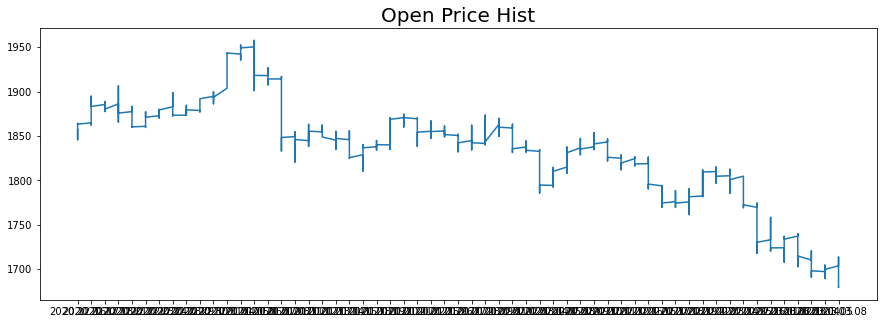

In [ ]:
dates = data_train[0].values
open_price = data_train[2].values

plt.figure(figsize=(15, 5))
plt.plot(dates, open_price)
plt.title('Open Price Hist', fontsize=20);

In [ ]:
# Fungsi di bawah menerima sebuah series/atribut kita yang telah di konversi menjadi tipe numpy, lalu mengembalikan label dan atribut dari dataset dalam bentuk batch.

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1]))
  return ds.batch(batch_size).prefetch(1)

In [ ]:
train_set = windowed_dataset(open_price, window_size=60, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < ((data_train[2].max() - data_train[2].min()) / 10) ):
      print("\nMAE dibawah 10%!")
      self.model.stop_training = True
callbacks = myCallback()

history = model.fit(train_set, epochs=100, callbacks=[callbacks])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
147/147 [==============================] - 21s 115ms/step - loss: 1830.8805 - mae: 1831.3805
Epoch 2/100
147/147 [==============================] - 17s 115ms/step - loss: 1753.6084 - mae: 1754.1085
Epoch 3/100
147/147 [==============================] - 17s 114ms/step - loss: 134.0757 - mae: 134.5729
Epoch 4/100
147/147 [==============================] - 17s 115ms/step - loss: 30.6037 - mae: 31.0987
Epoch 5/100
147/147 [==============================] - 17s 115ms/step - loss: 27.7526 - mae: 28.2475
Epoch 6/100
147/147 [==============================] - 17s 114ms/step - loss: 30.9241 - mae: 31.4188
Epoch 7/100
147/147 [==============================] - 17s 116ms/step - loss: 28.7860 - mae: 29.2812
Epoch 8/100
147/147 [==============================] - 17s 113ms/step - loss: 24.4099 - mae: 24.9042

MAE dibawah 10%!


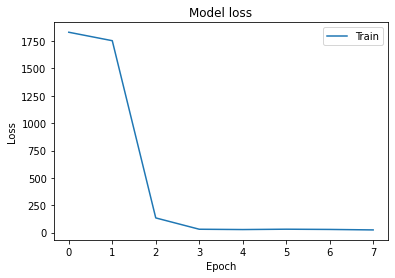

In [ ]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

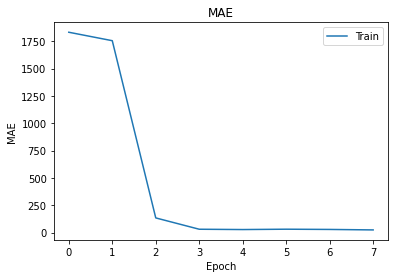

In [ ]:
plt.plot(history.history['mae'])
plt.title('MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()